## Vehicle Detection Project

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier
* Optionally, you can also apply a color transform and append binned color features, as well as histograms of color, to your HOG feature vector. 
* Note: for those first two steps don't forget to normalize your features and randomize a selection for training and testing.
* Implement a sliding-window technique and use your trained classifier to search for vehicles in images.
* Run your pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.

### Load image paths and explore dataset

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import random
import cv2
import glob
from skimage.feature import hog
from skimage import color, exposure
%matplotlib inline

# images are divided up into vehicles and non-vehicles
car_images_udacity = glob.glob(r'C:\Users\mohar\Desktop\Vinod\vehicles\*\*.png')
notcar_images_udacity = glob.glob(r'C:\Users\mohar\Desktop\Vinod\non-vehicles\*\*.png')

cars = []
notcars = []

for image in car_images_udacity:
    cars.append(image)

for image in notcar_images_udacity:
    notcars.append(image)
    
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    test_img = mpimg.imread(car_list[np.random.randint(0, len(car_list))])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = test_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = test_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])

Your function returned a count of 4050  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


### Helper functions

In [2]:
# Define a function to plot multiple images
def visualize(fig, rows, cols, imgs, titles):
    for i, img in enumerate(imgs):
        plt.subplot(rows, cols, i+1)
        plt.title(i+1)
        img_dims = len(img.shape)
        if img_dims < 3:
            plt.imshow(img, cmap = 'gray')
        else:
            plt.imshow(img)
        plt.title(titles[i])
        fig.subplots_adjust(hspace=.3)
        fig.subplots_adjust(wspace=.3)

In [3]:
# Define a function to visualize color histogram features of individual channels
def vis_color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the all channels separately
    ch1hist = np.histogram(img[:,:,0], nbins, bins_range)
    ch2hist = np.histogram(img[:,:,1], nbins, bins_range)
    ch3hist = np.histogram(img[:,:,2], nbins, bins_range)
    # Generating bin centers
    bin_centers = (ch1hist[1][:-1] + ch1hist[1][1:])/2
    # Plot a figure with all three bar charts
    if ch1hist is not None:
        fig = plt.figure(figsize=(12,3))
        plt.subplot(131)
        plt.bar(bin_centers, ch1hist[0])
        plt.xlim(0, 255)
        plt.title('Ch-1 Histogram')
        plt.subplot(132)
        plt.bar(bin_centers, ch2hist[0])
        plt.xlim(0, 255)
        plt.title('Ch-2 Histogram')
        plt.subplot(133)
        plt.bar(bin_centers, ch3hist[0])
        plt.xlim(0, 255)
        plt.title('Ch-3 Histogram')
        fig.tight_layout()
    else:
        print('Your function is returning None for at least one variable...')
    return None

In [4]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

In [5]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [6]:
# Define a function to compute color histogram features
def color_hist(img, nbins=32, bins_range=(0, 1)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [7]:
# Define a function to transition between colorspaces
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
    if conv == 'RGB2YUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    if conv == 'RGB2HSV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

In [8]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

In [9]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(image, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel='ALL',
                        spatial_feat=True, hist_feat=True, hog_feat=True, vis = False):    
    #1) Define an empty list to receive features and hog_img if vis = True
    img_features = []
    if color_space == 'RGB':
        # default channels for spatial and color histogram binning
        channels = (0,1,2)
    #2) Apply color conversion if other than 'RGB'
    if color_space != 'RGB':
        if color_space == 'HSV':
            channels = (0,1,2)
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            channels = (0,)
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
        elif color_space == 'YUV':
            channels = (0,)
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            channels = (0,)
            feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(image)      
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
    #4) Append features to list
        img_features.extend(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
    #6) Append features to list
        img_features.extend(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
            hog_features = np.ravel(hog_features)
        else:
            if vis == True:
                hog_features, hog_img = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=True, feature_vec=True)
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
                
    #8) Append features to list
        img_features.extend(hog_features)
    #9) Return concatenated array of features
    if vis == True:
        return img_features, hog_img
    else:
        return img_features

In [10]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,600:,:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2YCrCb')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 4  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    # Placeholder for storing bounding boxes
    bbox_list = []
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left+599, ytop_draw+ystart),(xbox_left+599+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                bbox_list.append(((xbox_left+599, ytop_draw+ystart),(xbox_left+599+win_draw,ytop_draw+win_draw+ystart)))
    return draw_img, bbox_list

In [11]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1
    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [12]:
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [13]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

### Visualize a few car and non-car images

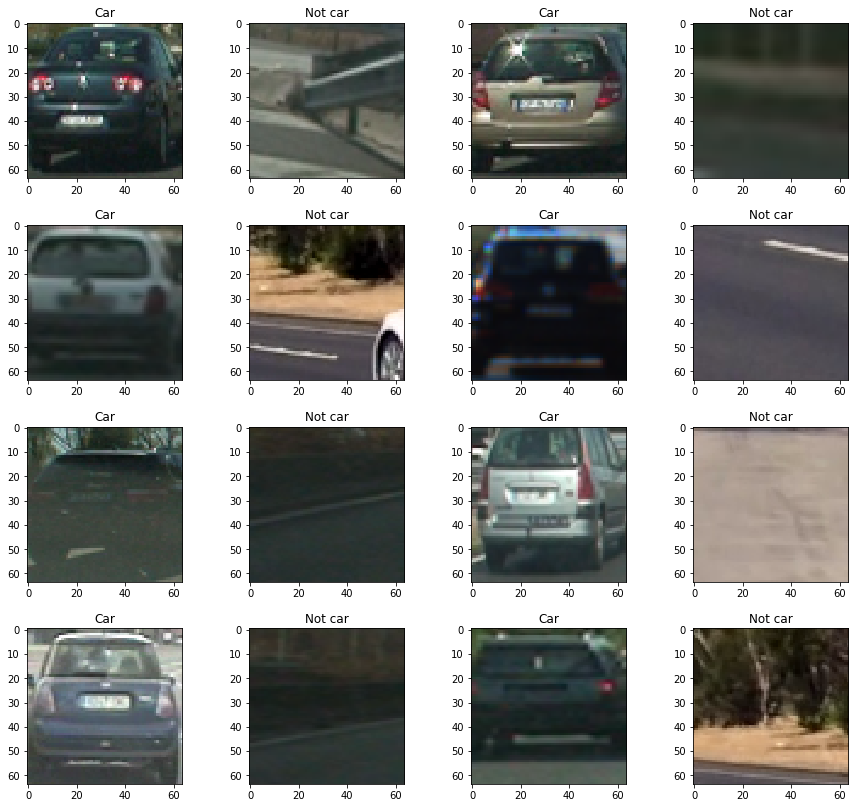

In [14]:
figure = plt.figure(figsize = (15,14))
imgs = []
for i in range(8):
    imgs.append(mpimg.imread(cars[np.random.randint(0, len(cars))]))
    imgs.append(mpimg.imread(notcars[np.random.randint(0, len(notcars))]))
titles = ['Car', 'Not car','Car', 'Not car','Car', 'Not car','Car', 'Not car',
         'Car', 'Not car','Car', 'Not car','Car', 'Not car','Car', 'Not car']
visualize(figure, 4, 4, imgs, titles)

### Read sample car and non-car images for hog visualizations

In [15]:
# Choose indices for visualization
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))

# read in sample car and non-car image
car_img = mpimg.imread(cars[car_ind])
notcar_img = mpimg.imread(notcars[notcar_ind])

### Visualize HOG features

C:\Users\mohar\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


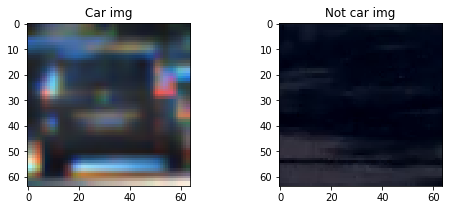

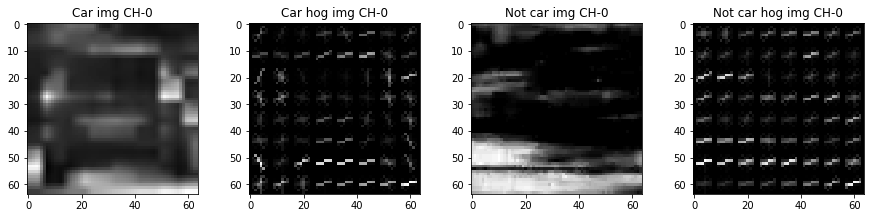

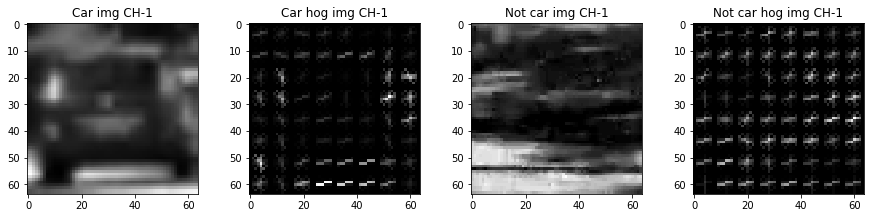

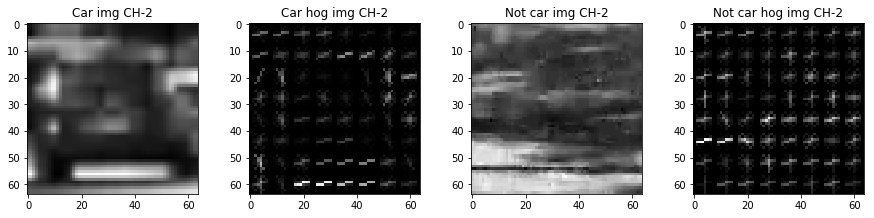

In [16]:
# Model parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

visualize_hog = [0, 1, 2]
# plot car and notcar image in rgb for comparison with extracted hog features
figure = plt.figure(figsize=(8,3))
imgs = [car_img, notcar_img]
titles = ['Car img','Not car img']
visualize(figure, 1, 2, imgs, titles)
    
for channel in visualize_hog:
    car_features, car_hog_img = single_img_features(car_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)

    notcar_features, notcar_hog_img = single_img_features(notcar_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat, vis=True)
    
    figure = plt.figure(figsize=(15,7))
    imgs = [car_img[:,:,channel], car_hog_img, notcar_img[:,:,channel], notcar_hog_img]   
    titles = ['Car img CH-' + str(channel), 'Car hog img CH-' + str(channel), 
              'Not car img CH-' + str(channel), 'Not car hog img CH-' + str(channel)]
    visualize(figure, 1, 4, imgs, titles)

### Building a classifier using linear support vector machine (svm)

In [17]:
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import svm, datasets
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
### Model parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32 # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off

# Check time for extracting features
t = time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to extract features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2 - t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

C:\Users\mohar\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


72.29 Seconds to extract features...
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
34.16 Seconds to train SVC...
Test Accuracy of SVC =  0.9831


In [18]:
import pickle
# save the model to disk
filename = 'finalized_model1.sav'
pickle.dump(svc, open(filename, 'wb'))

0.07166666666666667 Seconds to predict...
0.09999999999999999 Seconds to predict...
0.07666666666666667 Seconds to predict...
0.07666666666666667 Seconds to predict...
0.07833333333333332 Seconds to predict...
0.08 Seconds to predict...


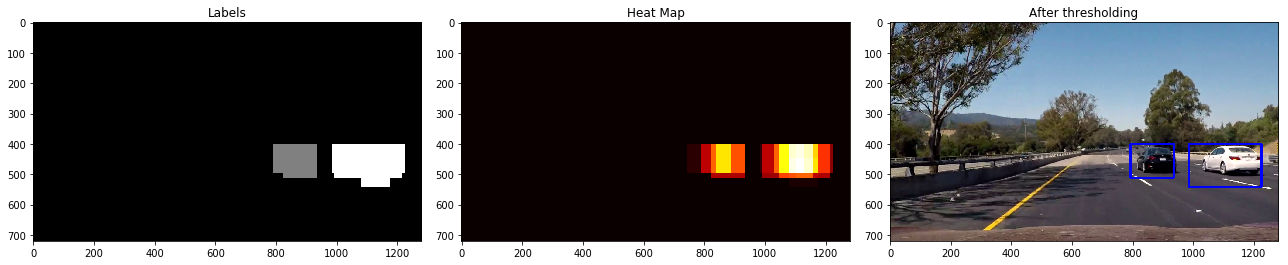

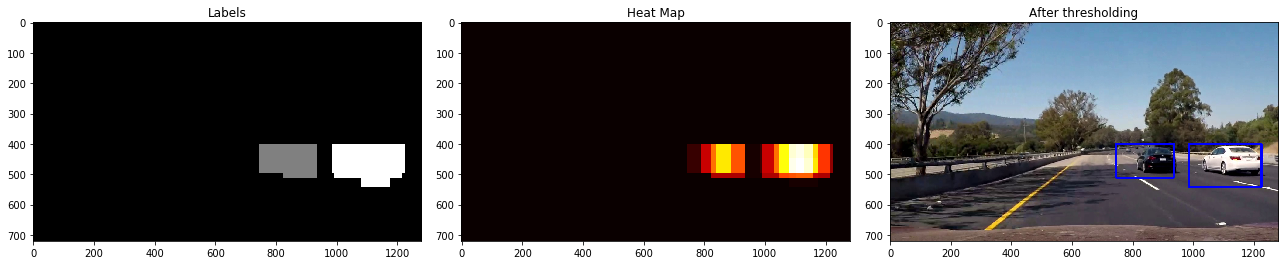

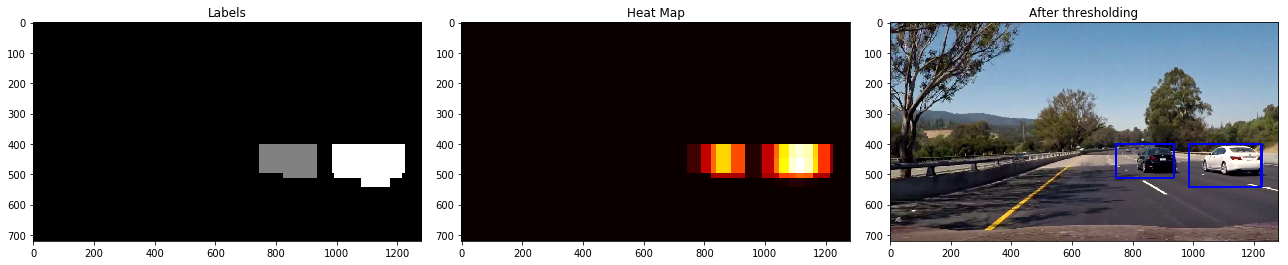

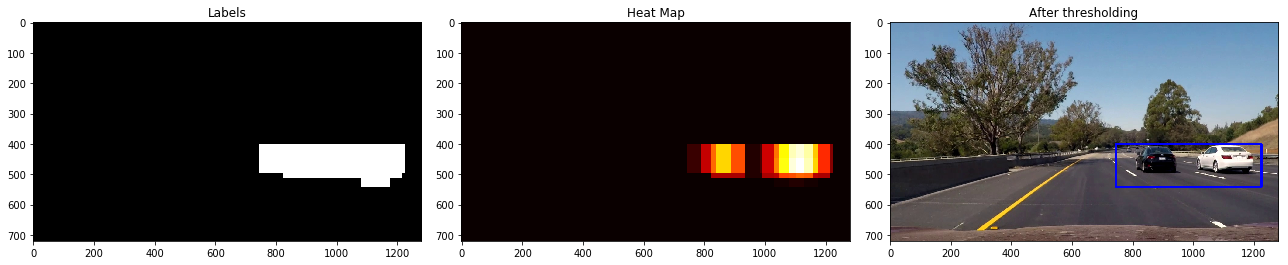

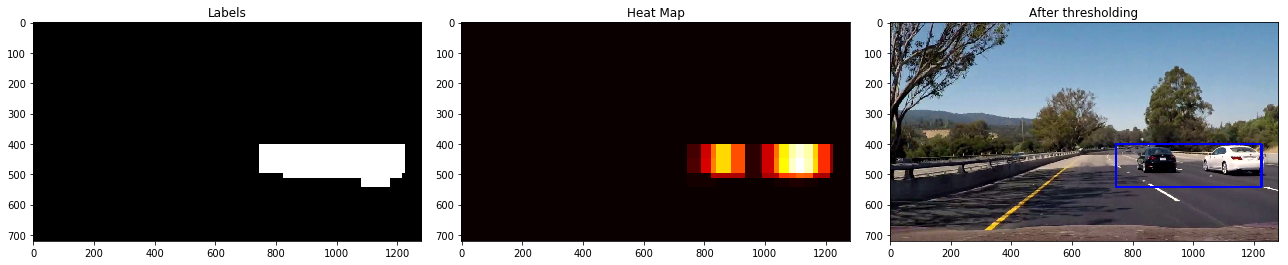

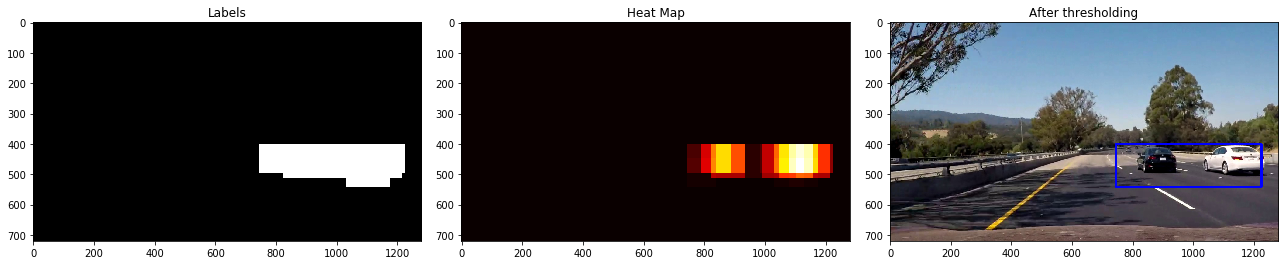

In [35]:
from scipy.ndimage.measurements import label
import collections

# test_imgs = glob.glob(r'C:\Users\mohar\Desktop\Vinod\Self-Driving-Car-NanoDegree-Udacity\\
# Term1-Computer-Vision-and-Deep-Learning\Project5-Vehicle-Detection-and-Tracking\test_images\*.jpg')

test_imgs = glob.glob(r'C:\Users\mohar\Desktop\Vinod\Self-Driving-Car-NanoDegree-Udacity\\
Term1-Computer-Vision-and-Deep-Learning\Project5-Vehicle-Detection-and-Tracking\\raw\test\*.jpg')

ystart = 400
ystop = 656
bboxes = []
heatmaps = collections.deque(maxlen=10)
for img in test_imgs[:15]:
    # Check the training time for the SVC
    t = time.time()
    read_img = mpimg.imread(img)
    heatmap = np.zeros_like(read_img[:,:,0]).astype(np.float)
    out_img, bbox_list1 = find_cars(read_img, ystart, ystop, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.append(bbox_list1)    
    _, bbox_list2 = find_cars(read_img, ystart, ystop, 1.75, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.append(bbox_list2)
    bbox_list = [item for sublist in bboxes for item in sublist] 
    if len(out_img>0):
        current_heatmap = add_heat(heatmap, bbox_list)
        heatmaps.append(current_heatmap)
    if(len(list(heatmaps))>=10):
        heatmap_sum = sum(heatmaps)
        heat = np.clip(apply_threshold(heatmap_sum, 3), 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heat)
        draw_img = draw_labeled_bboxes(np.copy(read_img), labels)

        fig = plt.figure(figsize=(18,8))
        plt.subplot(131), plt.imshow(labels[0], cmap = 'gray'), plt.title('Labels')
        plt.subplot(132), plt.imshow(heatmap, cmap='hot'), plt.title('Heat Map')
        plt.subplot(133), plt.imshow(draw_img), plt.title('After thresholding')
        fig.tight_layout()
        t2 = time.time()
        print(round(t2 - t, 2)/6.0, 'Seconds to predict...')

### Define a class to keep track of detections from previous frames

In [20]:
import collections

def pipeline_img(frame):
    bboxes = []
    heatmap = np.zeros_like(frame[:,:,0])
    out_img, bbox_list1 = find_cars(frame, ystart, ystop, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.append(bbox_list1)
    
#     _, bbox_list2 = find_cars(frame, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     bboxes.append(bbox_list2)
    
#     _, bbox_list3 = find_cars(frame, ystart, ystop, 2.25, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     bboxes.append(bbox_list3)
    
    _, bbox_list4 = find_cars(frame, ystart, ystop, 1.75, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.append(bbox_list4)
    
    bbox_list = [item for sublist in bboxes for item in sublist] 
    if len(out_img>0):
        current_heatmap = add_heat(heatmap, bbox_list)
        heatmaps.append(current_heatmap)
    if(len(list(heatmaps))>=0):    # change this to 5 for video processing, 0 for individual frames
        heatmap_sum = sum(heatmaps)
        heat = np.clip(apply_threshold(heatmap_sum, 3), 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heat)
        draw_img = draw_labeled_bboxes(np.copy(frame), labels)
        return draw_img
    else:
        return frame

def pipeline_vid(frame):
    bboxes = []
    heatmap = np.zeros_like(frame[:,:,0])
    out_img, bbox_list1 = find_cars(frame, ystart, ystop, 1.5, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.append(bbox_list1)
    
#     _, bbox_list2 = find_cars(frame, ystart, ystop, 2.0, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     bboxes.append(bbox_list2)
    
#     _, bbox_list3 = find_cars(frame, ystart, ystop, 2.25, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#     bboxes.append(bbox_list3)
    
    _, bbox_list4 = find_cars(frame, ystart, ystop, 1.75, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    bboxes.append(bbox_list4)
    
    bbox_list = [item for sublist in bboxes for item in sublist] 
    if len(out_img>0):
        current_heatmap = add_heat(heatmap, bbox_list)
        heatmaps.append(current_heatmap)
    if(len(list(heatmaps))>=5):    # change this to 5 for video processing, 0 for individual frames
        heatmap_sum = sum(heatmaps)
        heat = np.clip(apply_threshold(heatmap_sum, 3), 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heat)
        draw_img = draw_labeled_bboxes(np.copy(frame), labels)
        return draw_img
    else:
        return frame

### Test the pipeline on a few test images

C:\Users\mohar\AppData\Local\conda\conda\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


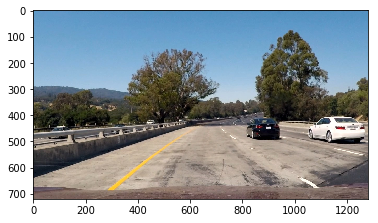

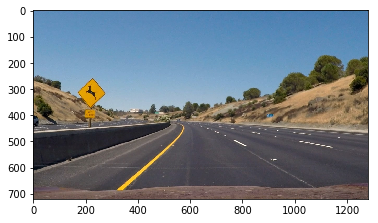

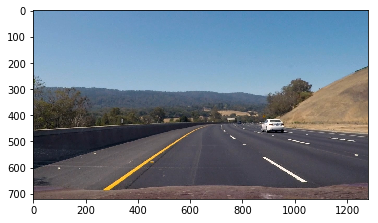

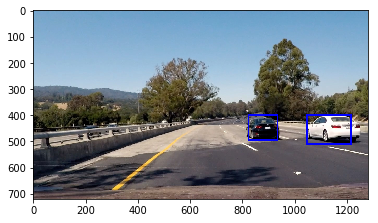

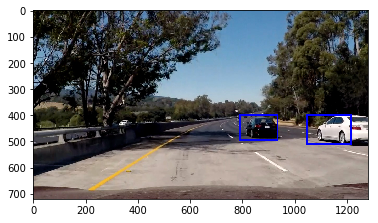

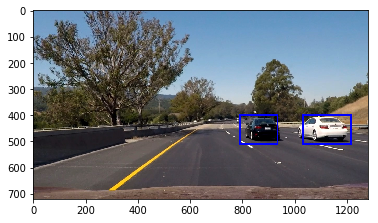

In [21]:
# check if the pipeline is working
heatmaps = collections.deque(maxlen=10) 
for frame in test_imgs:
    plt.figure(figsize=(6,8))
    read_img = mpimg.imread(frame)
    plt.imshow(pipeline_img(read_img))

### Process video

In [24]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

heatmaps = collections.deque(maxlen=10)
output = 'project_video_output_v1_9.mp4'
#clip = VideoFileClip("test_video.mp4")
clip = VideoFileClip("project_video.mp4")

white_clip = clip.fl_image(pipeline_vid)

%time white_clip.write_videofile(output, audio=False)
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))

[MoviePy] >>>> Building video project_video_output_v1_9.mp4
[MoviePy] Writing video project_video_output_v1_9.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [04:37<00:00,  4.82it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output_v1_9.mp4 

Wall time: 4min 38s
